In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf

import argparse
import os
import time
import glob

import data.my_dataset_loader as dataset_loader
import unet

In [ ]:
logits

In [ ]:
labels

In [2]:
# Params
NUM_CLASSES = 2
BATCH_SIZE = 1
MAX_EPOCHS = 5
LEARNING_RATE = 1e-4
LEARNING_RATE_DECAY_STEPS = 10000
LEARNING_RATE_DECAY_RATE = 0.9
WEIGHT_DECAY_RATE = 0.0005
CHECKPOINT_DIR = '../Datasets/checkpoints'
DATA_DIR = '../Datasets/training'

# Load training data
filenames = dataset_loader.find_image_files(DATA_DIR)
train_images,train_labels = dataset_loader.read_image_files(filenames)

# Placeholders
num_images = np.shape(train_images)[0]
width = np.shape(train_images)[1]
height = np.shape(train_images)[2]
channel = np.shape(train_images)[3]
images = tf.placeholder(tf.float32, shape=(BATCH_SIZE, width, height, channel))
labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, width, height, NUM_CLASSES))

# Build Unet
logits = unet.build(images, NUM_CLASSES, True)
#accuarcy = unet.accuracy(logits, labels)
class_weight_tensor = None # load class weights if available
loss = unet.loss(logits, labels, WEIGHT_DECAY_RATE, class_weight_tensor)

global_step = tf.Variable(0, name = 'global_step', trainable = False)
#train_op = unet.train(loss, LEARNING_RATE_DECAY_STEPS, LEARNING_RATE_DECAY_STEPS, LEARNING_RATE_DECAY_RATE, global_step)
train_op = unet.train(loss, 1e-4, 10000, 0.9, global_step)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

saver = tf.train.Saver()
session_manager = tf.train.SessionManager(local_init_op = tf.local_variables_initializer())
sess = session_manager.prepare_session("", init_op = init_op, saver = saver, checkpoint_dir = CHECKPOINT_DIR)

writer = tf.summary.FileWriter(CHECKPOINT_DIR + "/train_logs", sess.graph)

merged = tf.summary.merge_all()

#coord = tf.train.Coordinator()

try:
    #while not coord.should_stop():
    for epoch in range(MAX_EPOCHS):
        for i in range(num_images // BATCH_SIZE):
            batch_xs = train_images[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            batch_ys = train_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            #step = tf.train.global_step(sess, global_step)
            _, loss_value, summary = sess.run([train_op, loss, merged],{images: batch_xs, labels: batch_ys})

            print('[PROGRESS]\tStep %d: loss = %.2f' % (i, loss_value))

#    writer.add_summary(summary, step)

    #if step % 2 == 0:
        #acc_seg_value = sess.run([accuarcy])

        #epoch = step * BATCH_SIZE / data_size
        #duration = time.time() - start_time
        #start_time = time.time()

        #print('[PROGRESS]\tEpoch %d, Step %d: loss = %.2f, accuarcy = %.2f (%.3f sec)' % (epoch, step, loss_value, acc_seg_value, duration))

    #if step % 2 == 0:
        #print('[PROGRESS]\tSaving checkpoint')
        #checkpoint_path = os.path.join(FLAGS.checkpoint_dir, 'unet.ckpt')
        #saver.save(sess, checkpoint_path, global_step = step)

except tf.errors.OutOfRangeError:
    #print('[INFO    ]\tDone training for %d epochs, %d steps.' % (MAX_EPOCHS, step))
    print('[INFO    ]\tDone training for %d epochs.' % (MAX_EPOCHS))

finally:
    # When done, ask the threads to stop.
    #coord.request_stop()
    print('Done.')

[PROGRESS]	Determining list of input files from ../Datasets/training
[INFO    ]	Found 15 images inside ../Datasets/training.
[INFO    ]	Total 15 images and labels are read. The shape of train_images is (15, 256, 256, 1).
[PROGRESS]	Step 0: loss = 130.30
[PROGRESS]	Step 1: loss = 121.95
[PROGRESS]	Step 2: loss = 117.54
[PROGRESS]	Step 3: loss = 105.12
[PROGRESS]	Step 4: loss = 95.74
[PROGRESS]	Step 5: loss = 97.21
[PROGRESS]	Step 6: loss = 95.46
[PROGRESS]	Step 7: loss = 123.35
[PROGRESS]	Step 8: loss = 100.16
[PROGRESS]	Step 9: loss = 85.70
[PROGRESS]	Step 10: loss = 85.98
[PROGRESS]	Step 11: loss = 70.04
[PROGRESS]	Step 12: loss = 43.27
[PROGRESS]	Step 13: loss = 108.89
[PROGRESS]	Step 14: loss = 68.27
[PROGRESS]	Step 0: loss = 205.85
[PROGRESS]	Step 1: loss = 94.59
[PROGRESS]	Step 2: loss = 82.76
[PROGRESS]	Step 3: loss = 60.85
[PROGRESS]	Step 4: loss = 66.54
[PROGRESS]	Step 5: loss = 67.93
[PROGRESS]	Step 6: loss = 70.76
[PROGRESS]	Step 7: loss = 101.77
[PROGRESS]	Step 8: loss = 87.

In [48]:
saver.save(sess, CHECKPOINT_DIR)

'../Datasets/checkpoints'

In [4]:
TEST_DATA_DIR = '../Datasets/testing'
filenames = dataset_loader.find_image_files(TEST_DATA_DIR)
test_images,test_labels = dataset_loader.read_image_files(filenames)

[PROGRESS]	Determining list of input files from ../Datasets/testing
[INFO    ]	Found 2 images inside ../Datasets/testing.
[INFO    ]	Total 2 images and labels are read. The shape of train_images is (2, 256, 256, 1).


In [60]:
predicted_images = unet.predict(logits, BATCH_SIZE, 256)
predicted_images_value = sess.run([predicted_images],{images: np.expand_dims(test_images[1], axis=0), labels: np.expand_dims(test_labels[0], axis=0)})
#output_out = sess.run({images: np.expand_dims(test_images[1], axis=0), labels: np.expand_dims(test_labels[0], axis=0)})

In [64]:
np.shape(predicted_images_value)
predicted_images_value = np.squeeze(predicted_images_value)
np.shape(predicted_images_value)

(256, 256)

In [78]:
a = np.squeeze(test_labels[1])
b = np.zeros((256,256)).astype(int)
for i in range(255):
    for j in range(255):
        b[i][j]=int(a[i][j][0]*(1/255))

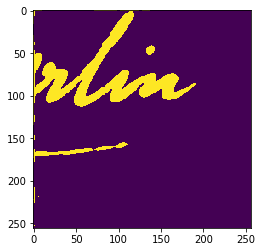

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(predicted_images_value)
plt.show()

In [79]:
np.sum(predicted_images_value-b)

6018

In [77]:
np.shape(b)

(255, 255)

In [ ]:
from __future__ import print_function

import numpy as np
import tensorflow as tf

import argparse
import os
import time
import glob

import data.my_dataset_loader as dataset_loader
import unet

# Param
BATCH_SIZE = 15
NUM_EPOCHS = 5
CHECKPOINT_DIR = '../Datasets/checkpoints'
DATA_DIR = '../Datasets/training'

# Load training data
filenames = dataset_loader.find_image_files(DATA_DIR)
train_images,train_labels = dataset_loader.read_image_files(filenames)

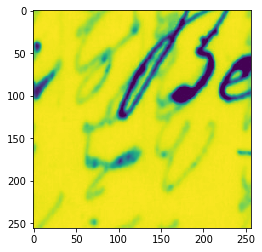

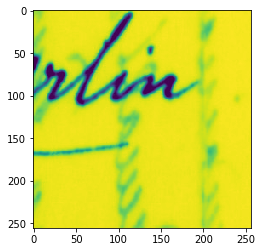

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(np.squeeze(test_images[0]))
plt.show()
#plt.imshow(np.squeeze(test_labels[0]))
#plt.show()
plt.imshow(np.squeeze(test_images[1]))
plt.show()
#plt.imshow(np.squeeze(test_labels[1]))
#plt.show()

In [ ]:
a = np.dstack((train_labels[14], 255.-np.squeeze(train_labels[14])))

In [ ]:
np.max(255.-np.squeeze(train_labels[14]))

In [ ]:
batch_ys

In [ ]:
# NOT USING
images, labels, filenames = dataset_loader.inputs(
        data_files = data_files,
        image_size = 512,
        batch_size = 8,
        num_epochs = 1,
        train = True)

In [ ]:
# Customize



In [ ]:
logits = unet.build(images, 1, True)

In [ ]:
logits

In [ ]:
class_weight_tensor = None
loss = unet.loss(logits, labels, 0.0005, class_weight_tensor)
loss

In [ ]:
# NOT USING
for example in tf.python_io.tf_record_iterator("../Datasets/tfrecords/training-00000-of-00001.tfrecords"):
    result = tf.train.Example.FromString(example)
    print(result)


In [ ]:
step = tf.train.global_step(sess, global_step)



In [ ]:
#IMAGE READER
import numpy as np
import tensorflow as tf

import os
import random

from image_coder import ImageCoder

def find_image_files(data_dir):
    """
    Build a list of all images files in the data set:
    ----------
    Args:
        data_dir: string, path to the root directory of images. Assumes
        (data_dir/image.png) format

    Returns:
        filenames: list of strings; each string is a path to an image file
        following the format data_dir/image%s.png, %s will be replaced
        with color, depth or annoation extension image_color.png
    """

    print('[PROGRESS]\tDetermining list of input files from %s' % data_dir)

    filenames = []

    # Construct the list of image files
    color_file_path = os.path.join(data_dir, '*%s.*') % ('_image')
    label_file_path = os.path.join(data_dir, '*%s.*') % ('_label')

    color_files = tf.gfile.Glob(color_file_path)
    label_files = tf.gfile.Glob(label_file_path)

    assert len(color_files) == len(label_files)

    #matching_files = [ x.replace('_image', '_image') for x in color_files ]
    matching_files = [ x.replace('_image', '%s') for x in color_files ]
    filenames.extend(matching_files)

    # Shuffle the ordering of all image files in order to guarantee randomness
    #shuffled_index = range(len(filenames))
    #random.seed(12345)
    #random.shuffle(shuffled_index)

    #filenames = [filenames[i] for i in shuffled_index]

    print('[INFO    ]\tFound %d images inside %s.' % (len(filenames), data_dir))

    print(filenames)
    return filenames


def read_image_files(filenames):
    
    image_lists = []
    label_lists = []
    coder = ImageCoder()
    for filename in filenames:
        # Concat
        image_file = filename % '_image'
        label_file = filename % '_label'
        
        # Read the image file.
        with tf.gfile.FastGFile(image_file, 'r') as f:
            image_data = f.read()
        # Decode the PNG
        image = coder.decode_png(image_data)
        # Check that image converted to RGB
        assert len(image.shape) == 3
        #height = image.shape[0]
        #width = image.shape[1]
        assert image.shape[2] == 1
        #print(image.shape[0],image.shape[1],image.shape[2]) 
        image_lists.append(image)
        
        # Read the label file.
        with tf.gfile.FastGFile(label_file, 'r') as f:
            label_data = f.read()
        # Decode the PNG
        label = coder.decode_png(label_data)
        # Check that image converted to RGB
        assert len(label.shape) == 3
        #height = image.shape[0]
        #width = image.shape[1]
        assert label.shape[2] == 1
        #print(image.shape[0],image.shape[1],image.shape[2]) 
        label_lists.append(label)
        
    print('[INFO    ]\tTotal %d images and labels are read. The shape of train_images is %s.' % (len(filenames), np.shape(image_lists)))
    return (image_lists,label_lists)
    

filenames = find_image_files("../Datasets/training")
train_images,train_labels = read_image_files(filenames)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(np.squeeze(train_images[3]))
plt.show()

In [ ]:
import tensorflow as tf
filename_queue = tf.train.string_input_producer(
    tf.train.match_filenames_once("../Datasets/training/*.png"))

image_reader = tf.WholeFileReader()

# Read a whole file from the queue, the first returned value in the tuple is the
# filename which we are ignoring.
_, image_file = image_reader.read(filename_queue)

# Decode the image as a JPEG file, this will turn it into a Tensor which we can
# then use in training.
image = tf.image.decode_png(image_file)
train_data = []
with tf.Session() as sess:
    
    # Required to get the filename matching to run.
    tf.local_variables_initializer().run()

    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Get an image tensor and print its value.
    image_tensor = sess.run([image])
    train_data.append(image_tensor)
    #print(image_tensor)

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

In [ ]:
import numpy as np
np.shape(train_data)